# TFIDF Word2Vec + Dense NN

__Author__: Severin Kappeler

__Created__: 07.04.2020

__Version__: 1

__Description__: Creates sentence embedding based on tf-idf and word-embedding and feeds this in a NN




|Change ID | Date       |  Author             |Change Description                   |
|----------|------------|---------------------|--------------------------------------|


In [2]:
# see also 06-Natural-Language_processing notebooks. This one focuses only on doc2vec.
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
import os
import smart_open
import collections
import scipy.stats as stats
import tensorflow as tf
import gensim
import tqdm
import warnings
import sys
import os

from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from gensim.test.utils import get_tmpfile

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
from matplotlib import cm
import matplotlib.colors as mcolors
from numpy.random import multivariate_normal

%matplotlib inline

from nltk import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
#from sklearn.model_selection import GridSearchCV, RandomSearch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import svm, tree
import xgboost

/home/sevi/anaconda3/envs/propulsion2020/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sevi/anaconda3/envs/propulsion2020/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sevi/anaconda3/envs/propulsion2020/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sevi/anaconda3/envs/pr

# Preprocessing

## Import & Cleaning

In [3]:
path = '/home/sevi/Desktop/Work/PropulsionDS/GroupChallenges/RelevApp/10_cleaning/src'

current_path = os.getcwd()
os.chdir(path)
%run ./Load+Clean_News.ipynb
os.chdir(current_path)

[nltk_data] Downloading package stopwords to /home/sevi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
news

,SimilarityScore,sentence1,sentence2
0,4.000,last year wa want murder,last year wa sought murder
1,5.000,promarket economist dont object corpor blatantli use snob appeal promot product,economist compani openli use attract luxuri promot product
2,5.000,perhap importantli ahmadinejad destabil influenc bernank,perhap import ahmadinejad destabilis influenc bernank
3,4.667,europ,europ
4,4.500,gay modern practic reject selfindulg,gay practic modern reject law
...,...,...,...
649,1.800,indian pakistani govern nearli engag fourth conflict 1999,indian pakistani govern conduct nuclear test may 1998
650,3.800,iguaran state detaine accus homicid crimin collabor kidnap fund terror,iguaran state detaine also involv murder polic member antikidnap group
651,2.400,3 suspect extremist releas bail,1 suspect extremist wa provision releas without bail
652,0.800,6 czech hospit employe charg human organ traffick,accus charg intern drug traffick


In [5]:
#create list of all document strings
documents = news['sentence1']
documents = documents.append(news['sentence2'])
#documents.drop_duplicates(inplace = True)
documents = documents.reset_index(drop = True)

#
#create list of document strings split by sentence (a list for each document where each document is represented by a list of sentences (strings))
doc_sent = tokenize_to_sentences(documents)
#create list of document strings split by cleaned sentences
doc_sent_clean = [[clean_sentence(sentence) for sentence in document] for document in doc_sent]

In [6]:
documents[0:2]

0                                                           last year wa want murder
1    promarket economist dont object corpor blatantli use snob appeal promot product
dtype: object

In [7]:
doc_sent[0:2]

0                                                           [last year wa want murder]
1    [promarket economist dont object corpor blatantli use snob appeal promot product]
dtype: object

In [8]:
doc_sent_clean[0:2]

[['last year wa want murder'],
 ['promarket economist dont object corpor blatantli use snob appeal promot product']]

In [9]:
#Build Corpus: #SK01
#runtime: 15''
def build_corpus(data):
    return [nltk.word_tokenize(sentence) for doc in data for sentence in doc]

corpus = build_corpus(doc_sent_clean)

In [10]:
#Number of sentences overall (can contain duplicates!):
len(corpus)

1308

# Embedding

## Word2Vec (Pretrained Google News)

In [11]:
# Importing pre-trained model, updating vocab 
# and training the model (takes long to run)
#runtime without google: 18''
model_2 = Word2Vec(size=300, min_count=1, window = 5)
model_2.build_vocab(corpus)
total_examples = model_2.corpus_count

# #for testing commented out:
# model_pt = gensim.models.KeyedVectors.load_word2vec_format('/home/sevi/Desktop/Work/PropulsionDS/Pretrained/GoogleNews-vectors-negative300.bin', binary=True)
# model_2.build_vocab([list(model_pt.vocab.keys())], update=True)
# model_2.intersect_word2vec_format('/home/sevi/Desktop/Work/PropulsionDS/Pretrained/GoogleNews-vectors-negative300.bin', binary=True, lockf=1.0)

# intersect_word2vec_format() will let you bring vectors from an external file into a model that's already had its own vocabulary initialized
# see https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.intersect_word2vec_format.html
model_2.train(corpus, total_examples=total_examples, epochs=model_2.iter)

/home/sevi/anaconda3/envs/propulsion2020/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  from ipykernel import kernelapp as app


(52756, 56900)

In [12]:
#model_2.wv.vectors contains 26'668 vectors of length 300
print(len(model_2.wv.vectors))
print(len(model_2.wv.vectors[0]))
print(len(model_2.wv.vocab))


1888
300
1888


## TF-IDF

In [13]:
doc_clean = [' '.join(document) for document in doc_sent_clean]

In [14]:
#SK02
#this function creates the (for now only global) TF-IDF weights for each word.
def calc_tf_idf(cleaned_doc_str = None):
    '''
    This function expects as an input for each document the already cleaned string wrapped in a list. 
    Then it returns all the TF-IDF scores for each word and document in the matrix tfid_matrix.
    
    Attributes:
    - cleaned_doc_str: List of strings
            Default = None
            This list contains for each document the string of its content. The string is expected to already be cleaned and stopwords removed.
    '''
     
    #Calculate TF-IDF score for all words in the corpus
    tfidf = TfidfVectorizer(
          sublinear_tf=True
        , min_df=1
        , norm='l2'
        , encoding='latin-1'
        , ngram_range=(1,1)  #considering only 1-grams for now
        , token_pattern= '(?u)\\b\\w+\\b' #changed from default in order to also include single letters in case they appear in the corpus.
        , tokenizer=nltk.word_tokenize #we pass the corpus as words already.
        , stop_words=None #we already removed stopwords
    ) 
    tfidf_matrix = tfidf.fit_transform(cleaned_doc_str)#.toarray()
    
        
    if(not(len(tfidf.get_feature_names()) == len(model_2.wv.vocab.keys()))):
        warnings.warn('The count of vocabulary from the word embedding does not coincide with the TF-IDF Vectorizer features.')
    
    return tfidf
    #None
    #tfidf_matrix contains TF-IDF scores for each document (in the rows) and word (in the columns)
    #tfidf.get_feature_names() gives you the words in the order 

In [15]:
def get_sentence_vector(sent_clean_token=None, model=None, fitted_tfidf=None):
    '''
    This function is to average all words vectors in a given sentence.

    Parameters
    ----------
    sent_clean_token : string
            a string representing a sentence
    model : model
            a word embedding model (f.e. Word2Vec) featuring model['example_word']
    fitted_tfidf : fitted TfidfVectorizer
            pass the TF-IDF Vectorizer fitted to the dictionary
    '''
    #words = word_tokenize(clean_sentence(sentence))

    sent_len = len(sent_clean_token)
    total_weight = fitted_tfidf.vocabulary_[sent_clean_token[0]]
    sentenceVec = model.wv[sent_clean_token[0]] * fitted_tfidf.vocabulary_[sent_clean_token[0]]
    for i in range(1, sent_len):
        sentenceVec = sentenceVec + model.wv[sent_clean_token[i]] * fitted_tfidf.vocabulary_[sent_clean_token[i]]
        total_weight += fitted_tfidf.vocabulary_[sent_clean_token[i]]
                            
    return sentenceVec/total_weight

In [16]:
doc_clean = [' '.join(document) for document in doc_sent_clean]    
doc_word_tfidf = calc_tf_idf(doc_clean)
sent_clean = [sentence for document in doc_sent_clean for sentence in document]

In [17]:
#nr_docs = doc_word_tfidf.shape[0]    
sent_embedding_matrix = np.zeros((len(corpus), 300))

#embedding_matrix is 26'668 x 300 matrix 
for idx, sent in enumerate(corpus):
    sent_embedding_matrix[idx] = get_sentence_vector(corpus[idx],model_2,doc_word_tfidf)

In [18]:
print(len(sent_embedding_matrix[0]))
print(len(sent_embedding_matrix))

300
1308


# Sense Check

## Most Similar

In [19]:
sent_embedding_matrix

array([[-2.35404310e-04,  1.25421677e-03,  5.38284250e-04, ...,
         3.08027188e-03,  6.74286915e-04, -6.66367356e-04],
       [ 2.08893543e-05,  8.82641878e-04,  4.45087906e-04, ...,
         1.84106920e-03,  1.08379312e-03,  1.58953917e-04],
       [ 2.05704389e-04,  1.19285025e-04, -6.11500436e-05, ...,
         1.95142569e-03,  1.85111864e-03, -7.32902263e-05],
       ...,
       [-5.86987240e-04,  1.19237031e-03, -3.29074974e-04, ...,
         2.67418777e-03,  1.46171020e-03, -6.83803984e-04],
       [-7.96415625e-05,  7.26199592e-04,  7.58215310e-06, ...,
         3.13720480e-03,  1.25322177e-03, -7.48376071e-04],
       [-2.31666650e-06, -4.02498408e-04,  1.20806193e-03, ...,
         1.58382556e-03, -1.18538330e-04, -1.45731930e-04]])

In [20]:
sent_all = news_raw['sentence1']
sent_all = sent_all.append(news_raw['sentence2'])
#sent_all.drop_duplicates(inplace = True)
sent_all = np.array(sent_all)

In [21]:
def most_similar_sent(sent = '', n = 10, embedding_matrix = None, sent_all = None):
    idxes = np.where(sent_all == sent)[0]
    search_vector = embedding_matrix[idxes[0]]
    
    #calculate cosine similarity
    cos_sim = cosine_similarity([search_vector], sent_embedding_matrix)

    most_similar_idxes = cos_sim[0].argsort()[::-1]
    #exclude the sentence index where the sentence is identical to the input
    most_similar_idxes = most_similar_idxes[~(np.isin(most_similar_idxes, idxes))]
    
    return sent_all[most_similar_idxes[0:n]]   

In [22]:
most_similar_sent(
        sent = 'The answer lies in the support that Indonesian pro-democracy activists can generate domestically and internationally.'
        , n = 10
        , embedding_matrix = sent_embedding_matrix
        , sent_all = sent_all
    )

array(['The answer lies in the support that the Indonesian democrats will generate activists domestically and internationally.',
       'The answer lies in the support that the Indonesian democrats activists will generate domestically and internationally.',
       'The answer lies in the support that the Indonesian democrats activists will generate national and internationally.',
       'The answer lies in the support that democratic activists Indonesians may generate drive and internationally.',
       'The answer lies in the support that all will be able to generate nationally and internationally.  ',
       'The answer lies in the support that democratic activists Indonesia can generate nationalement and internationally.',
       'The answer is in the support that the democratic activists indonésiens will be able to generate nationally and internationally.',
       'the iranian government has dismissed the allegations in the intelligence presented to the international atomic energy 

## Find closest index

In [23]:
def get_similarity_index(sent1 = '', sent2 = '', embedding_matrix = None, sent_all = None):
    '''
    This function returns the index n such that the n-th closest sentence to sentence sent1 is sentence sent2.
    '''
    #sent1
    idxes1 = np.where(sent_all == sent1)[0]
    sent1_vector = embedding_matrix[idxes1[0]]

    #sent2
    idxes2 = np.where(sent_all == sent2)[0]
    sent2_vector = embedding_matrix[idxes2[0]]
    
    #calculate cosine similarity
    cos_sim = cosine_similarity([sent1_vector], sent_embedding_matrix)

    most_similar_idxes = cos_sim[0].argsort()[::-1]
    #exclude the sentence index where the sentence is identical to the input
    most_similar_idxes = most_similar_idxes[~(np.isin(most_similar_idxes, idxes1))]
    
    for i in range(len(most_similar_idxes)):
        i_th_sentence = sent_all[most_similar_idxes[i]]
        if(i_th_sentence == sent2):
            return i + 1

    return np.inf

In [24]:
get_similarity_index(
    sent1 = 'The answer lies in the support that Indonesian pro-democracy activists can generate domestically and internationally.'
    , sent2 = 'The answer lies in the support that all will be able to generate nationally and internationally.  '
    , embedding_matrix=sent_embedding_matrix
    , sent_all = sent_all
)
#correct

5

In [25]:
print(news_raw[652:653]['sentence1'].values[0])
print(news_raw[652:653]['sentence2'].values[0])
news_raw[652:653]

6 czech hospital employees are charged with human organ trafficking. 
the accused will be charged with international drug trafficking.


,SimilarityScore,sentence1,sentence2
652,0.8,6 czech hospital employees are charged with human organ trafficking.,the accused will be charged with international drug trafficking.


In [26]:
get_similarity_index(
    sent1 = news_raw[652:653]['sentence1'].values[0]
    , sent2 = news_raw[652:653]['sentence2'].values[0]
    , embedding_matrix=sent_embedding_matrix
    , sent_all = sent_all
)

1

In [27]:
most_similar_sent(
        sent = '6 czech hospital employees are charged with human organ trafficking. '
        , n = 10
        , embedding_matrix = sent_embedding_matrix
        , sent_all = sent_all
    )

array(['the accused will be charged with international drug trafficking.',
       'the accused will be charged with international drug trafficking. ',
       'afghan drug trafficker was caught in tajikistan.',
       'since 2006 mexico has adopted a series of measures against drug trafficking and organized crimes.',
       'bulgarian police arrest head of drug trafficking group.',
       'drug traffickers from foreign countries constitute the largest percentage of foreign inmates in nepal.',
       'the rapist was identified as hossein safarlou and had also been convicted of drug trafficking.',
       'the mexican government has adopted a series of measures against drug trafficking and organized crime within mexico since 2006. ',
       'a statement issued by the official spa news agency stated that-- al-dosari was convicted of drug trafficking. ',
       'syrian and russian officials signed an agreement of cooperation in combating drug trafficking.'],
      dtype=object)

## Visualization

In [31]:
news_raw[news_raw['SimilarityScore'] < 1]

,SimilarityScore,sentence1,sentence2
18,0.50,"They are ignorant, poor, and sick.",They are for the moment.
46,0.50,What we are witnessing today is a shift from a Muslim identity to an Islamist identity.,In the absence of a change of associations.
130,0.25,Being a Muslim and being an Islamist are not the same thing.,It is necessary to are two different things.
208,0.25,"Gays and other ""modern"" practices are rejected as self-indulgent.","The catch and other practices, because."
359,0.60,safe bourada was sentenced to 15 years in prison.,djamel badaoui was sentenced to five years.
382,0.00,alto huallaga is located northeast of the capital lima.,"puerto cabezas is located 557 km northeast of managua, nicaragua."
391,0.60,the deal has been in process for several years.,the iaea has been investigating iran's nuclear activities for 4 years.
423,0.80,abuja is the capital of,tskhinvali is the capital of georgia.
456,0.60,shingarev said it is very difficult to make a nuclear weapon from the plutonium in this fuel.,donohue said it is very difficult to manipulate radioactive isotopes without leaving a trail.
457,0.60,paris is the capital of france.,lima is the capital of


In [35]:
#calculate for each sentence pair:
news_raw['closest_percentile'] = news_raw.apply(lambda row: get_similarity_index(row['sentence1'], row['sentence2'], embedding_matrix=sent_embedding_matrix, sent_all = sent_all), axis = 1)

In [36]:
news_raw['closest_percentile'] = 1 - news_raw['closest_percentile']/news_raw[news_raw['closest_percentile'] != np.inf]['closest_percentile'].max()

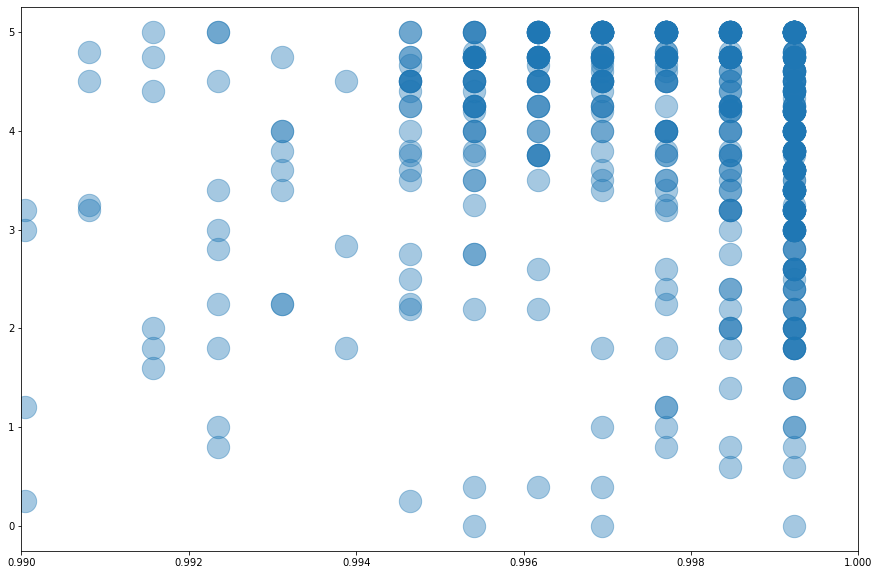

In [37]:
fig = plt.figure(figsize=(15,10))
plt.xlim(0.99,1)
plt.scatter(news_raw['closest_percentile'] ,news_raw['SimilarityScore'], alpha = 0.4, s = 500)


In [38]:
raw_sorted = news_raw.sort_values(by = 'closest_percentile', ascending=False)

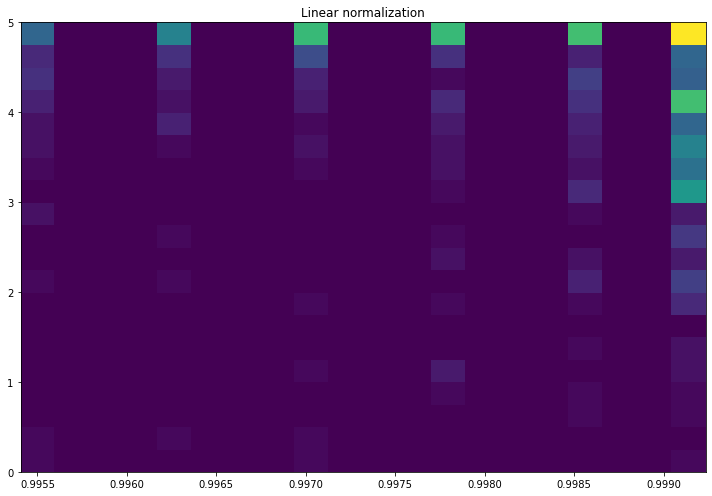

In [42]:
histo_data = news_raw[news_raw['closest_percentile'] >= 0.995]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,7))
ax.set_title('Linear normalization')
ax.hist2d(histo_data['closest_percentile'], histo_data['SimilarityScore'], bins=20)
fig.tight_layout()
plt.show()

In [40]:
simscore, bins = np.histogram(news_raw['SimilarityScore'], bins = 5)

In [257]:
plot_df = pd.DataFrame(news_raw[(news_raw['SimilarityScore'] >= bins[0]) & (news_raw['SimilarityScore'] < bins[1])]['closest_percentile'], columns = ['<1'])
i = 1
plot_df['<2'] = news_raw[(news_raw['SimilarityScore'] >= bins[i]) & (news_raw['SimilarityScore'] < bins[i+1])]['closest_percentile']
i = 2
plot_df['<3'] = news_raw[(news_raw['SimilarityScore'] >= bins[i]) & (news_raw['SimilarityScore'] < bins[i+1])]['closest_percentile']
i = 3
plot_df['<4'] = news_raw[(news_raw['SimilarityScore'] >= bins[i]) & (news_raw['SimilarityScore'] < bins[i+1])]['closest_percentile']
i = 4
plot_df['<5'] = news_raw[(news_raw['SimilarityScore'] >= bins[i]) & (news_raw['SimilarityScore'] < bins[i+1])]['closest_percentile']


# Dense NN

## Input Preparation

In [25]:
#the features are directly the sentence embeddings
X = sent_embedding_matrix

In [26]:
#SK04
def calc_target_per_sent(sentence_per_doc = None, target_original = None):
    
    current_target_idx = 0
    new_target = pd.DataFrame()
    for doc in sentence_per_doc:
        for sentence in doc:
            new_target = new_target.append(target.iloc[current_target_idx:current_target_idx+1])
            
        current_target_idx += 1

        
    return new_target.reset_index(drop = True)

In [27]:
target = calc_target_per_sent(doc_sent_clean, target)

NameError: name 'target' is not defined

In [80]:
# prepare the labels
y = pd.get_dummies(target)

In [81]:
print(len(X))
print(len(y))

10960
10960


In [82]:
X

array([[ 0.01354711, -0.0289998 , -0.04048988, ..., -0.06766372,
         0.25469464,  0.14217183],
       [ 0.01354711, -0.0289998 , -0.04048988, ..., -0.06766372,
         0.25469464,  0.14217183],
       [ 0.01354711, -0.0289998 , -0.04048988, ..., -0.06766372,
         0.25469464,  0.14217183],
       ...,
       [ 0.01354711, -0.0289998 , -0.04048988, ..., -0.06766372,
         0.25469464,  0.14217183],
       [ 0.01354711, -0.0289998 , -0.04048988, ..., -0.06766372,
         0.25469464,  0.14217183],
       [ 0.01354711, -0.0289998 , -0.04048988, ..., -0.06766372,
         0.25469464,  0.14217183]])

In [83]:
# split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## Define and Run Model

In [91]:
# init model
model = Sequential()
# emmbed word vectors
# model.add(Embedding(len(model_2.wv.vocab) + 1 ,
#                     300,
#                     input_length  = X.shape[1],
#                     #weights = [embedding_matrix],
#                     trainable=False))
# learn the correlations
#model.add(LSTM(300,return_sequences=False))
model.add(Dense(100, input_dim = len(X[0]))) 
model.add(Dense(12,activation="softmax")) 
# output model skeleton
model.summary()
model.compile(optimizer="nadam",loss="categorical_crossentropy",metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 12)                1212      
Total params: 31,312
Trainable params: 31,312
Non-trainable params: 0
_________________________________________________________________


In [92]:
batch = 64
epochs = 50
model.fit(X_train,y_train,batch,epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
9864/9864 [==============================] - 1s 63us/sample - loss: 2.3804 - acc: 0.1470
Epoch 2/50
9864/9864 [==============================] - 0s 41us/sample - loss: 2.3753 - acc: 0.1495
Epoch 3/50
9864/9864 [==============================] - 0s 43us/sample - loss: 2.3711 - acc: 0.1546
Epoch 4/50
9864/9864 [==============================] - 0s 41us/sample - loss: 2.3693 - acc: 0.1551
Epoch 5/50
9864/9864 [==============================] - 0s 38us/sample - loss: 2.3682 - acc: 0.1567
Epoch 6/50
9864/9864 [==============================] - 0s 41us/sample - loss: 2.3675 - acc: 0.1566
Epoch 7/50
9864/9864 [==============================] - 0s 40us/sample - loss: 2.3662 - acc: 0.1571
Epoch 8/50
9864/9864 [==============================] - 0s 40us/sample - loss: 2.3643 - acc: 0.1608
Epoch 9/50
9864/9864 [==============================] - 0s 39us/sample - loss: 2.3649 - acc: 0.1567
Epoch 10/50
9864/9864 [=============================

In [93]:
model.evaluate(X_test,y_test)

1096/1096 [==============================] - 0s 59us/sample - loss: 2.7316 - acc: 0.0438


[2.7316243892168477, 0.04379562]